### Resumen de los métodos y resultados del paper:

Se hicieron cuatro experimentos distintos:
1. Se entrenaron modelos con todo el dataset (menos "time").
2. Se entrenaron modelos con solo las dos features más importantes (serum creatinine y ejection fraction).
3. Se entrenó un modelo de stratified logistic regression con todo el dataset incluyendo el "time".
4. Se entrenó un modelo de stratified logistic regression con solo las dos features más importantes y el "time".

Los mejores resultados se obtuvieron en el experimento 4 (Ver sección "Survival prediction and feature ranking including the follow-up period").

In [36]:
%config InteractiveShell.ast_node_interactivity = 'all' # Mostrar varios outputs en la misma celda

## Parte 1

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('./heart_failure_clinical_records_dataset.csv')

In [38]:
df.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [39]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [40]:
non_booleans = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
]

booleans = list(filter(lambda e: e not in non_booleans, df.columns))
booleans = booleans[:-2]

<AxesSubplot:>

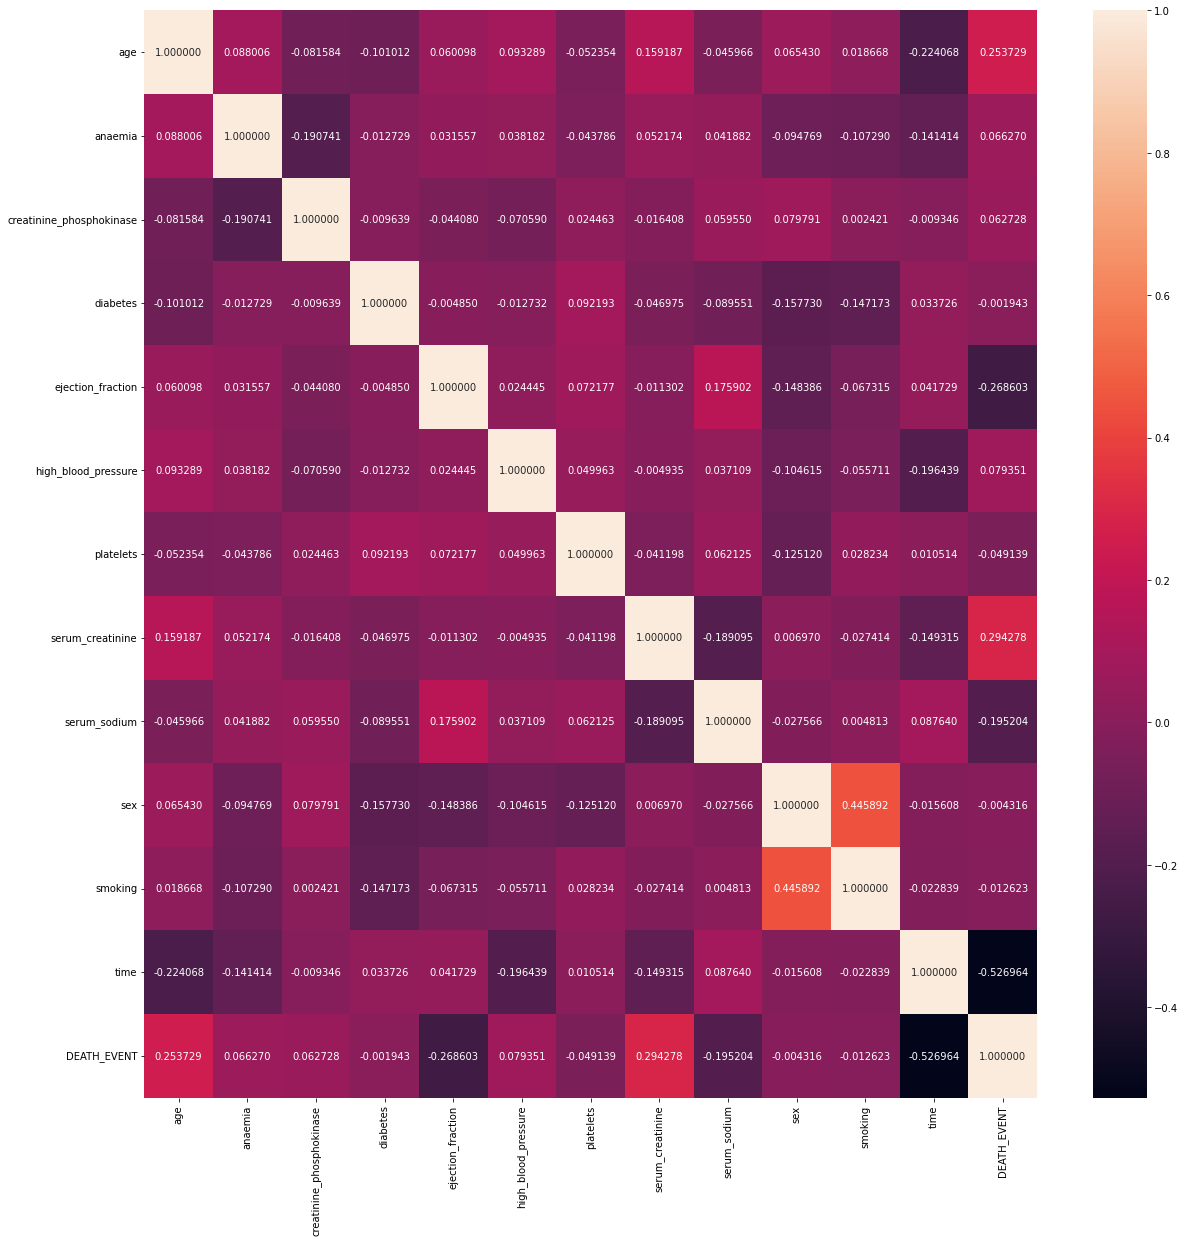

In [41]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), ax=ax, annot=True, fmt="f")

### Heatmap

Un primer EDA se hace con el Heatmap, que no muestra una fuerte correlación entre ninguna variable con la muerte. Los máximos están en time, age, serum_sodium, ejection_fraction y serum_creatinine, siendo los últimos dos los predichos por el Paper.

Esto coincide con los resultados obtenidos en el paper, como se puede ver en la siguiente imagen (No incluyen "time" para el "feature ranking"):

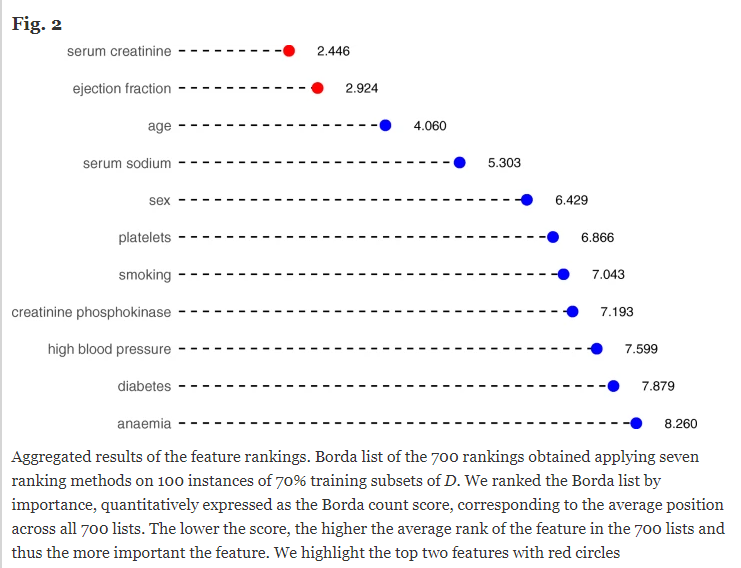

In [42]:
def boxplots(df, cols):
    fig, ax = plt.subplots(len(cols), figsize=(8,8*len(cols)))

    for i, column in enumerate(cols):
        sns.boxplot(y=column, data=df, ax=ax[i])


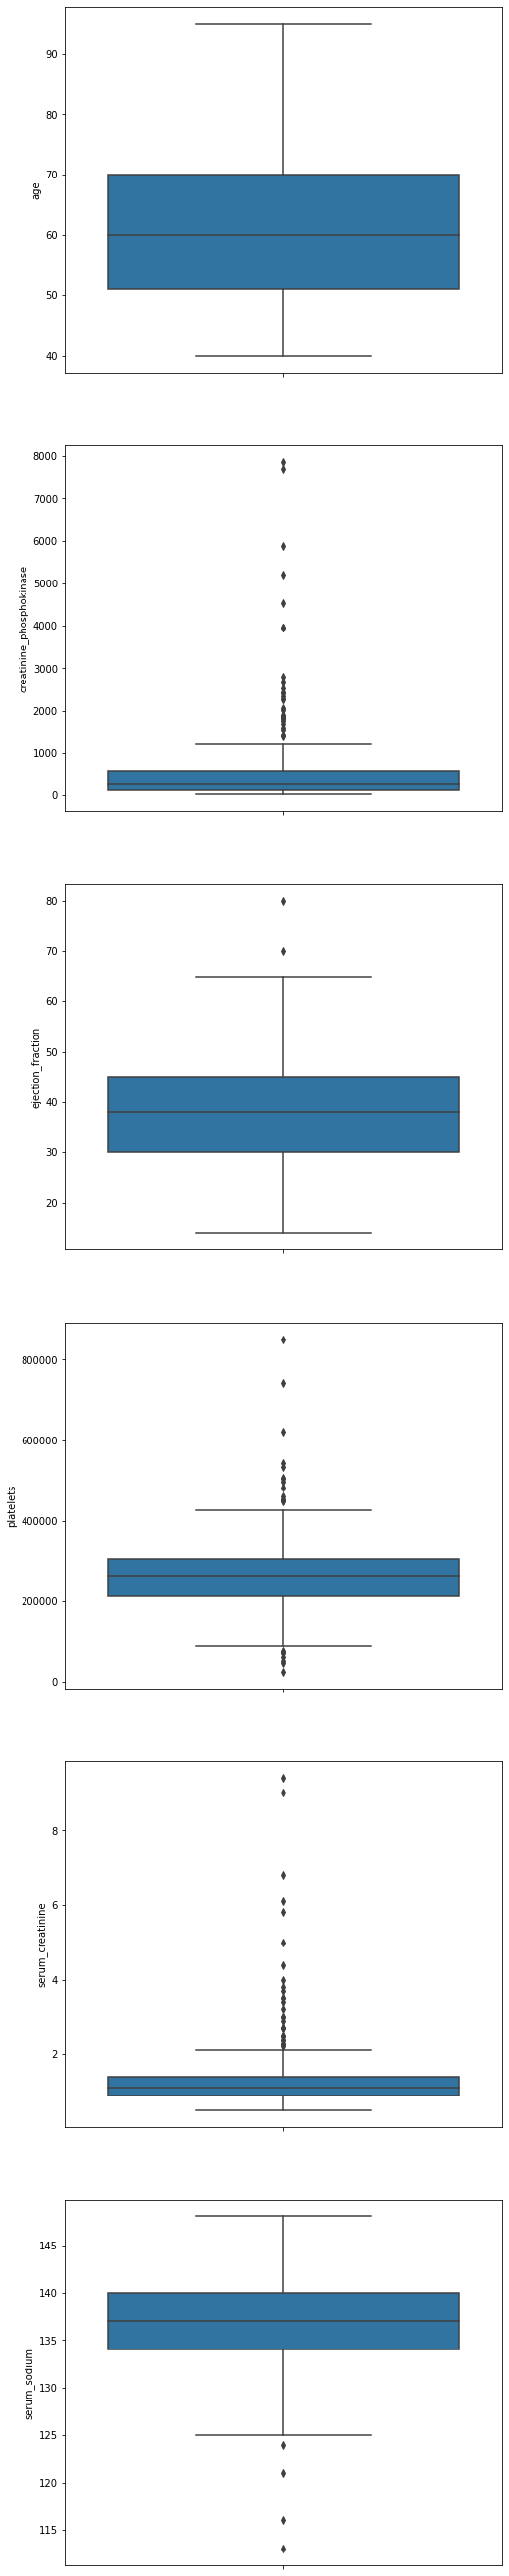

In [43]:
boxplots(df, non_booleans)

### Filtrado outliers

Para sacar outliers, por cada row, nos basamos en https://en.wikipedia.org/wiki/Box_plot]

Hallamos los márgenes superior e inferior, y, por cada columna, corroboramos que el valor de esa row quede dentro de los márgenes.

Obviamente que al sacar estos outliers surgen otros, debido a que los Qs cambian.

In [44]:
q3 = df[non_booleans].describe().iloc[6]
q1 = df[non_booleans].describe().iloc[4]
iqr = q3 - q1
iqr_margin = 1.5*iqr

In [45]:
minimum, maximum = q1-iqr_margin, q3+iqr_margin

In [46]:
filtered_df = df

for column in non_booleans:
    filtered_df = filtered_df.loc[(filtered_df[column] > minimum[column]) & (filtered_df[column] < maximum[column])]

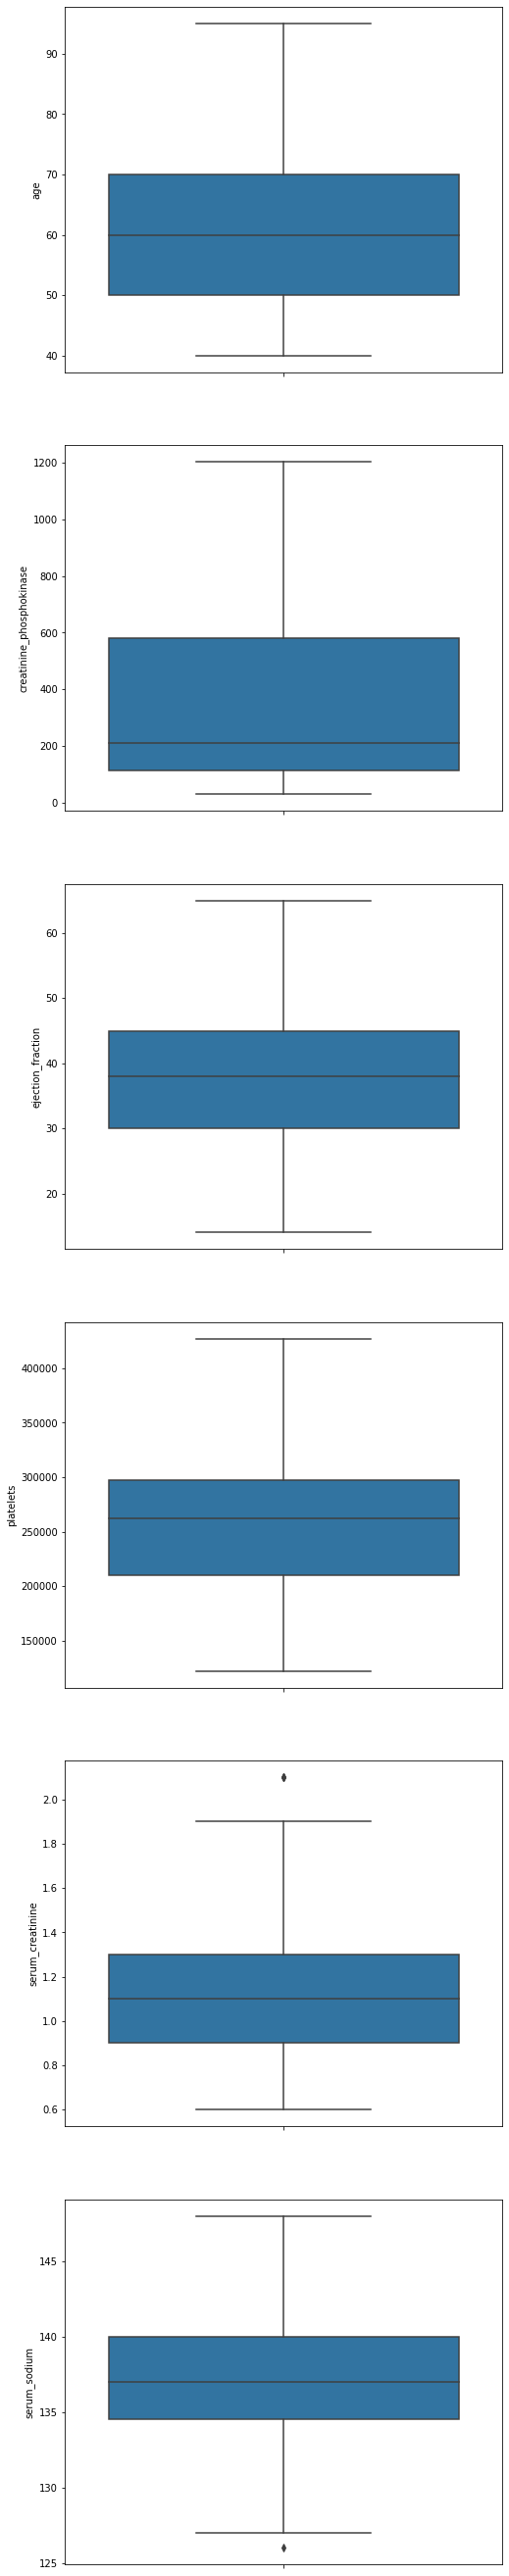

In [47]:
boxplots(filtered_df, non_booleans)

In [48]:
def histograms(df, cols):
    fig, ax = plt.subplots(len(cols), 2, figsize=(8,8*len(cols)))

    for i, column in enumerate(cols):
        df.loc[df['DEATH_EVENT']==0][column].value_counts().plot(kind='bar', ax=ax[i,0], title=f'{column} survivor')
        df.loc[df['DEATH_EVENT']==1][column].value_counts().plot(kind='bar', ax=ax[i,1], title=f'{column} not survivor')
    

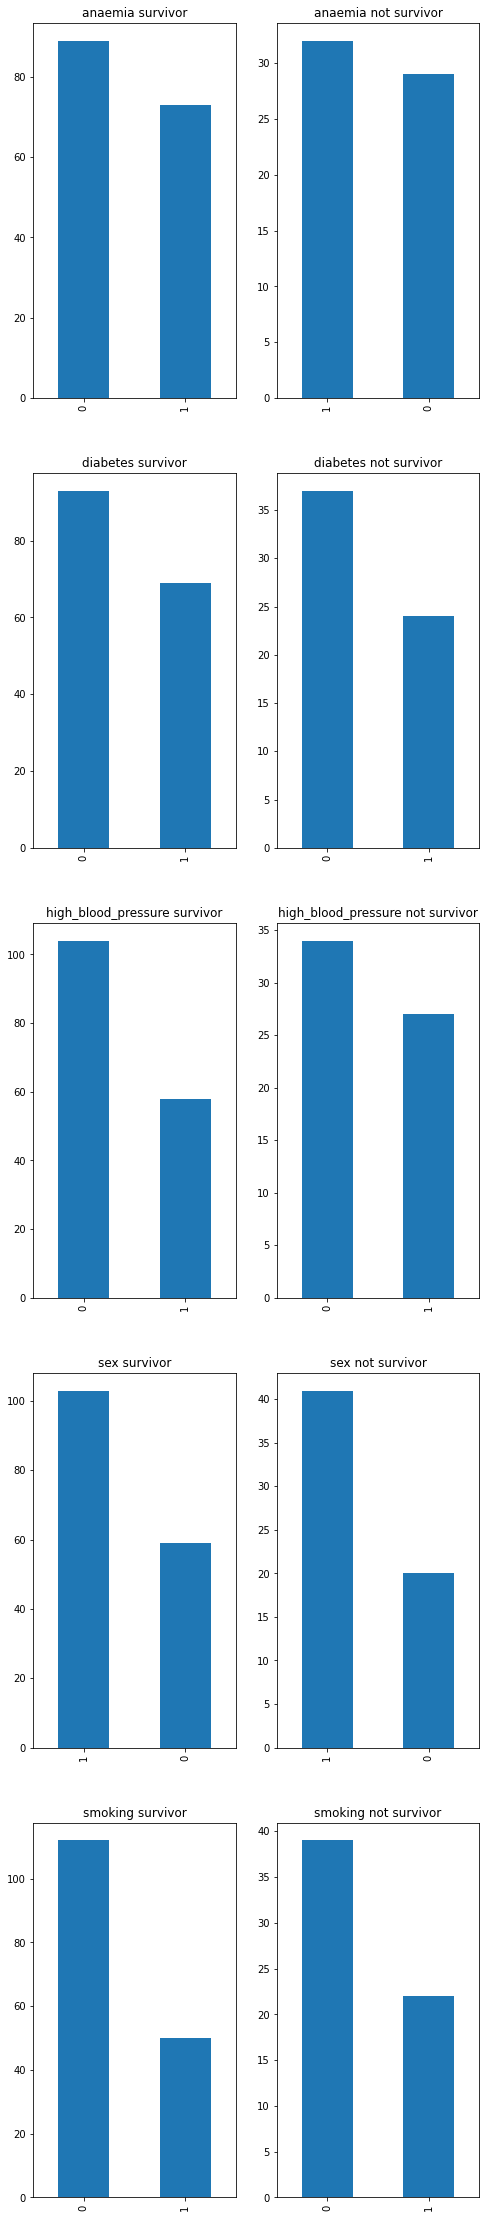

In [49]:
histograms(filtered_df, booleans)

### Analizando variables cualitativas

Comparando los histogramas que relacionan cada variable cualitativa con sobrevivir o no, vemos que no parece haber un indicio claro de que tenerla afecte la chance de sobrevivir. Es decir, la cantidad de personas que mueren son, por ejemplo, "tan fumadoras" como las que sobreviven, proporcionalmente.

Para que una condición lleve a la muerte, tiene que cumplirse que los vivos la tengan bastante (o no), y los muertos no la tengan (o sí). Por ejemplo, supongamos que ver la TV te mate. Entonces, el histograma de sobrevivientes hubiese mostrado una barra alta para los que no ven la TV y una baja para los que sí. El otro, en cambio, hubiese mostrado una barra alta para los que sí la ven , y una baja para los que no.

Claramente, no se analizan los números en sí mismos sino proporcionalmente, ya que el dataset tiene un 66% de sobrevivientes.

### Heatmap sin outliers

<AxesSubplot:>

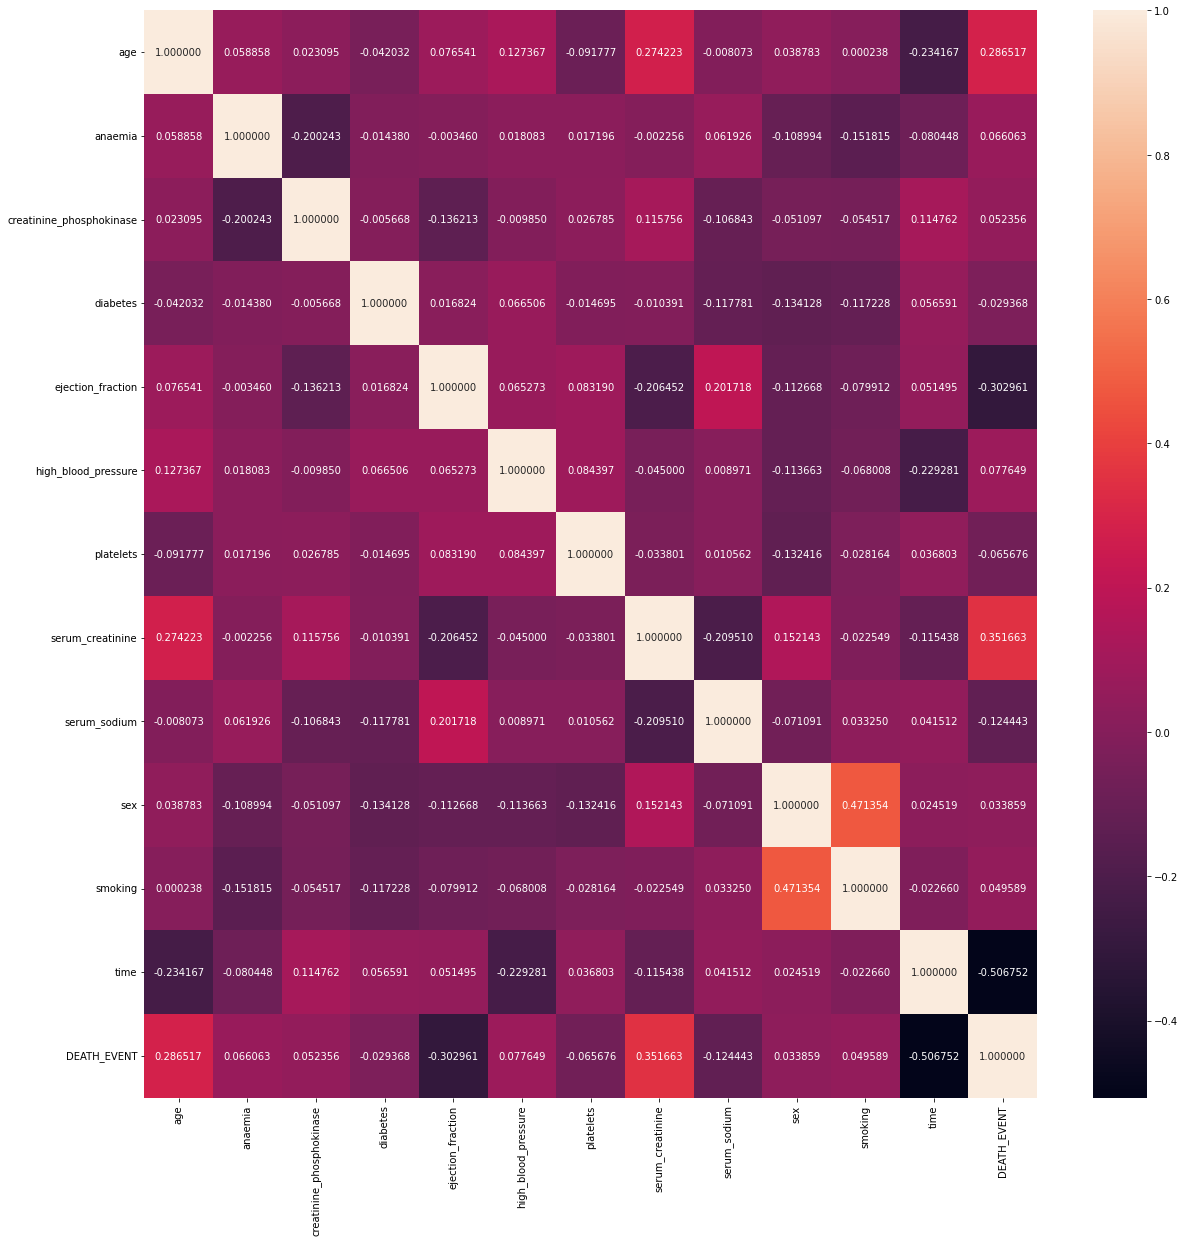

In [50]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(filtered_df.corr(), ax=ax, annot=True, fmt="f")

Al realiza el heatmap sin los outliers podemos ver que la correlación de DEATH_EVENT con las features que habíamos visto que eran las más importantes (serum_creatinine y ejection_fraction) subió mientras que serum_sodium que también era relativamente importante bajó. La tercera feature con mayor correlación sigue siendo age, que aumentó también.

## Parte 2:

En esta parte tomamos dos enfoques distintos: el primero es analizar "a ojo" el resultado de hacer un describe() de un dataframe con solo las personas que murieron y otro con solo las personas que sobrevivieron. Al hacer esto podemos ver si existe alguna diferencia notoria en alguna de las columnas.

El segundo enfoque es realizar una clusterización del dataframe y ver si alguno de los clusters tiene una concentración elevada de personas que fallecieron producto de un accidente cardiovascular. De esta forma podemos analizar los valores de las columnas de las filas de estos clusters y ver si podemos sacar conclusiones respecto a las características de las poblaciones con mayor riesgo de muerte producto de un accidente cardiovascular.

In [51]:
df_muertes = filtered_df[filtered_df['DEATH_EVENT'] == 1]
df_muertes.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.0
mean,66.306016,0.524590,359.196721,0.393443,32.344262,0.442623,248637.118689,1.314918,136.344262,0.672131,0.360656,69.213115,1.0
std,13.530662,0.503539,281.702610,0.492568,12.421601,0.500819,67959.570279,0.365439,4.036852,0.473333,0.484176,63.762610,0.0
min,42.000000,0.000000,47.000000,0.000000,14.000000,0.000000,126000.000000,0.600000,127.000000,0.000000,0.000000,4.000000,1.0
25%,57.000000,0.000000,129.000000,0.000000,25.000000,0.000000,200000.000000,1.000000,134.000000,0.000000,0.000000,23.000000,1.0
50%,68.000000,1.000000,246.000000,0.000000,30.000000,0.000000,254000.000000,1.200000,136.000000,1.000000,0.000000,43.000000,1.0
75%,75.000000,1.000000,582.000000,1.000000,38.000000,1.000000,284000.000000,1.600000,139.000000,1.000000,1.000000,95.000000,1.0
max,95.000000,1.000000,1199.000000,1.000000,65.000000,1.000000,418000.000000,2.100000,145.000000,1.000000,1.000000,241.000000,1.0


In [52]:
df_sobrevivientes = filtered_df[filtered_df['DEATH_EVENT'] == 0]
df_sobrevivientes.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.0
mean,58.652265,0.450617,326.475309,0.425926,40.240741,0.358025,258530.483519,1.056728,137.382716,0.635802,0.308642,156.092593,0.0
std,10.585702,0.499098,278.637105,0.496016,10.598140,0.480906,67064.222695,0.283286,3.577250,0.482697,0.463365,67.063223,0.0
min,40.000000,0.000000,30.000000,0.000000,17.000000,0.000000,122000.000000,0.600000,126.000000,0.000000,0.000000,12.000000,0.0
25%,50.000000,0.000000,102.250000,0.000000,35.000000,0.000000,218250.000000,0.900000,135.000000,0.000000,0.000000,94.000000,0.0
50%,60.000000,0.000000,205.000000,0.000000,38.000000,0.000000,263179.015000,1.000000,137.000000,1.000000,0.000000,147.500000,0.0
75%,65.000000,1.000000,582.000000,1.000000,45.000000,1.000000,300750.000000,1.200000,140.000000,1.000000,1.000000,212.750000,0.0
max,90.000000,1.000000,1202.000000,1.000000,62.000000,1.000000,427000.000000,2.100000,148.000000,1.000000,1.000000,285.000000,0.0


Creando un dataframe con solo las filas correspondientes a las personas que no pudieron sobrevivir al accidente cardiovascular, podemos hacer un describe() para ver las características de las poblaciones con mayor riesgo de muerte producto de este tipo de accidentes. También, hicimos un describe() del dataframe que incluye únicamente a los sobrevivientes para comparar los valores de las columnas.

Notamos lo siguiente:
- El promedio de edad es de 66 años lo cual se encuentra 8 años por arriba del promedio del dataset sin outliers.
- El promedio de días de seguimiento (columna "time") es más del doble para los pacientes que sobrevivieron. Esto puede significar que el tiempo de seguimiento está estrechamente relacionado a la probabilidad de morir a causa de un accidente cardiovascular o se puede deber a que los pacientes que murieron lo hicieron a los pocos días del accidente teniendo así un "follow-up period" menor.
- En promedio, "ejection_fraction" es mayor y "serum_creatinine" es menor para los pacientes que sobrevivieron.
- En promedio, los pacientes que murieron tienen una presión arterial mayor que los que sobrevivieron.

Hubiéramos esperado ver cosas como que las personas que murieron eran en su mayoría fumadoras pero no hay una diferencia muy visible en este aspecto. Lo mismo con la diabetes, es más, en este caso, hay un mayor porcentaje de diabéticos en los pacientes que sobrevivieron. Esperábamos esto porque estos dos factores aparecen listados como factores de riesto en: https://www.semanadelcorazon.com.uy/2020/enfermedades-cardiovasculares/

A continuación se procederá a realizar una clusterización del dataset para ver si se puede obtener algo más de información acerca de las características de las poblaciones con mayor riesgo de muerte producto de un accidente cardiovascular.

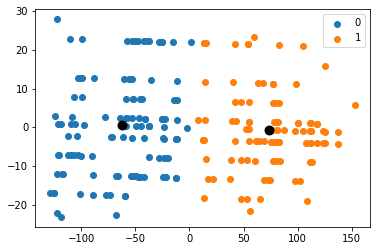

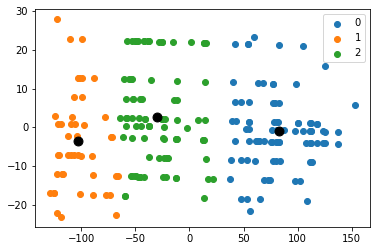

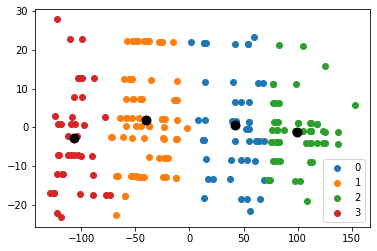

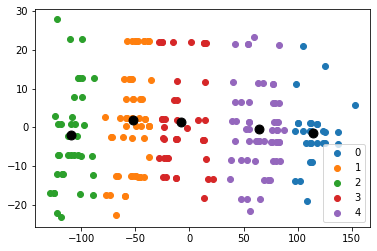

In [53]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

def cluster_kmeans(data, n_clusters):
    pca = PCA(2)
    df = pca.fit_transform(data)
    
    kmeans = KMeans(n_clusters=n_clusters)
    label = kmeans.fit_predict(df)

    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)

    #plotting the results:
    for i in u_labels:
        plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()
    return label

relevant_columns = [
    'serum_creatinine',
    'ejection_fraction',
    'time'
]
label_2_clusters = cluster_kmeans(filtered_df[relevant_columns], 2)
label_3_clusters = cluster_kmeans(filtered_df[relevant_columns], 3)
label_4_clusters = cluster_kmeans(filtered_df[relevant_columns], 4)
label_5_clusters = cluster_kmeans(filtered_df[relevant_columns], 5)

In [54]:
clustered_filtered_df = filtered_df
clustered_filtered_df.insert(13, "label_2_clusters", label_2_clusters, True)
clustered_filtered_df.insert(14, "label_3_clusters", label_3_clusters, True)
clustered_filtered_df.insert(15, "label_4_clusters", label_4_clusters, True)
clustered_filtered_df.insert(16, "label_5_clusters", label_5_clusters, True)

#### Análisis 2 clusters:

In [55]:
clustered_filtered_df[clustered_filtered_df['label_2_clusters'] == 0].describe()
clustered_filtered_df[clustered_filtered_df['label_2_clusters'] == 1].describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.0,121.000000,121.000000,121.000000
mean,62.892562,0.495868,310.685950,0.380165,38.082645,0.462810,253660.647355,1.152893,137.016529,0.628099,0.330579,70.107438,0.413223,0.0,1.619835,1.669421,1.776860
std,12.164019,0.502062,266.299331,0.487446,12.791004,0.500688,65131.492996,0.342667,3.658286,0.485322,0.472377,36.208149,0.494460,0.0,0.487446,0.960802,0.800912
min,41.000000,0.000000,30.000000,0.000000,14.000000,0.000000,122000.000000,0.600000,126.000000,0.000000,0.000000,4.000000,0.000000,0.0,1.000000,0.000000,1.000000
25%,53.000000,0.000000,109.000000,0.000000,30.000000,0.000000,210000.000000,0.900000,135.000000,0.000000,0.000000,33.000000,0.000000,0.0,1.000000,1.000000,1.000000
50%,62.000000,0.000000,185.000000,0.000000,38.000000,0.000000,255000.000000,1.100000,137.000000,1.000000,0.000000,79.000000,0.000000,0.0,2.000000,1.000000,2.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,297000.000000,1.300000,140.000000,1.000000,1.000000,95.000000,1.000000,0.0,2.000000,3.000000,2.000000
max,95.000000,1.000000,981.000000,1.000000,65.000000,1.000000,427000.000000,2.100000,145.000000,1.000000,1.000000,134.000000,1.000000,0.0,2.000000,3.000000,3.000000


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000
mean,58.199353,0.441176,364.774510,0.460784,38.078431,0.284314,258390.825882,1.097059,137.196078,0.666667,0.313725,206.137255,0.107843,1.0,0.254902,1.098039,2.617647
std,11.190153,0.498980,292.427393,0.500921,10.182188,0.453315,70026.238923,0.308688,3.825499,0.473732,0.466298,34.623588,0.311714,0.0,0.670249,1.000097,1.807816
min,40.000000,0.000000,54.000000,0.000000,17.000000,0.000000,126000.000000,0.600000,129.000000,0.000000,0.000000,140.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,50.000000,0.000000,123.750000,0.000000,35.000000,0.000000,216000.000000,0.900000,134.000000,0.000000,0.000000,186.000000,0.000000,1.0,0.000000,0.000000,0.000000
50%,58.000000,0.000000,238.000000,0.000000,38.000000,0.000000,263358.030000,1.000000,137.000000,1.000000,0.000000,209.000000,0.000000,1.0,0.000000,2.000000,4.000000
75%,65.000000,1.000000,582.000000,1.000000,40.000000,1.000000,299250.000000,1.200000,140.000000,1.000000,1.000000,236.500000,0.000000,1.0,0.000000,2.000000,4.000000
max,90.000000,1.000000,1202.000000,1.000000,62.000000,1.000000,422000.000000,2.100000,148.000000,1.000000,1.000000,285.000000,1.000000,1.0,2.000000,2.000000,4.000000


En el cluster 0 un 41% de las personas fallecieron mientras que en el 1 fue un 10%. Notamos que, contraintuitivamente, en el cluster 1 hay un mayor porcentaje de diabéticos. Sin embargo, en el cluster 0 los pacientes tienen en promedio mayor "creatinine_phosphokinase", mayor probabilidad de tener presión alta, mayor "serum_creatinine", son más fumadores (aunque no significativamente) y tienen un "follow-up period" mucho menor.

#### Análisis 3 clusters:

In [56]:
clustered_filtered_df[clustered_filtered_df['label_3_clusters'] == 0].describe()
clustered_filtered_df[clustered_filtered_df['label_3_clusters'] == 1].describe()
clustered_filtered_df[clustered_filtered_df['label_3_clusters'] == 2].describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0,89.0,89.000000,89.000000
mean,58.138584,0.426966,365.775281,0.449438,37.853933,0.292135,259185.463034,1.110112,137.022472,0.651685,0.280899,214.820225,0.101124,1.0,0.0,1.258427,2.561798
std,11.509638,0.497440,295.878613,0.500255,9.601788,0.457320,71880.889932,0.319373,3.858219,0.479136,0.451985,27.861493,0.303200,0.0,0.0,0.971504,1.930350
min,40.000000,0.000000,54.000000,0.000000,17.000000,0.000000,126000.000000,0.600000,129.000000,0.000000,0.000000,170.000000,0.000000,1.0,0.0,0.000000,0.000000
25%,50.000000,0.000000,129.000000,0.000000,35.000000,0.000000,215000.000000,0.900000,134.000000,0.000000,0.000000,192.000000,0.000000,1.0,0.0,0.000000,0.000000
50%,56.000000,0.000000,244.000000,0.000000,38.000000,0.000000,260000.000000,1.000000,137.000000,1.000000,0.000000,212.000000,0.000000,1.0,0.0,2.000000,4.000000
75%,65.000000,1.000000,582.000000,1.000000,40.000000,1.000000,301000.000000,1.200000,140.000000,1.000000,1.000000,241.000000,0.000000,1.0,0.0,2.000000,4.000000
max,90.000000,1.000000,1202.000000,1.000000,62.000000,1.000000,422000.000000,2.100000,148.000000,1.000000,1.000000,285.000000,1.000000,1.0,0.0,2.000000,4.000000


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0,46.0,46.000000,46.000000
mean,65.152174,0.521739,293.760870,0.434783,33.673913,0.543478,255270.263478,1.234565,136.869565,0.630435,0.347826,29.565217,0.847826,0.0,1.0,2.782609,1.826087
std,14.137370,0.505047,252.492568,0.501206,12.587568,0.503610,73743.258330,0.357949,3.997825,0.488021,0.481543,17.774704,0.363158,0.0,0.0,0.629393,0.383223
min,42.000000,0.000000,47.000000,0.000000,14.000000,0.000000,127000.000000,0.600000,127.000000,0.000000,0.000000,4.000000,0.000000,0.0,1.0,1.000000,1.000000
25%,50.750000,0.000000,111.250000,0.000000,25.000000,0.000000,201000.000000,1.000000,134.250000,0.000000,0.000000,14.250000,1.000000,0.0,1.0,3.000000,2.000000
50%,65.000000,1.000000,158.000000,0.000000,30.000000,1.000000,258000.000000,1.100000,137.000000,1.000000,0.000000,27.500000,1.000000,0.0,1.0,3.000000,2.000000
75%,72.000000,1.000000,580.750000,1.000000,40.000000,1.000000,295000.000000,1.300000,139.750000,1.000000,1.000000,40.250000,1.000000,0.0,1.0,3.000000,2.000000
max,95.000000,1.000000,981.000000,1.000000,65.000000,1.000000,427000.000000,2.100000,145.000000,1.000000,1.000000,66.000000,1.000000,0.0,1.0,3.000000,2.000000


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.00000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0,88.000000,88.000000
mean,61.079545,0.488636,326.511364,0.375000,40.613636,0.386364,252714.366364,1.08875,137.295455,0.647727,0.352273,102.613636,0.147727,0.147727,2.0,0.840909,1.931818
std,10.428984,0.502735,274.742847,0.486897,12.410074,0.489706,59140.892621,0.31182,3.474568,0.480416,0.480416,24.182939,0.356863,0.356863,0.0,0.367857,1.003390
min,40.000000,0.000000,30.000000,0.000000,20.000000,0.000000,122000.000000,0.60000,126.000000,0.000000,0.000000,68.000000,0.000000,0.000000,2.0,0.000000,1.000000
25%,55.000000,0.000000,100.500000,0.000000,30.000000,0.000000,218750.000000,0.90000,135.000000,0.000000,0.000000,82.750000,0.000000,0.000000,2.0,1.000000,1.000000
50%,60.000000,0.000000,199.000000,0.000000,40.000000,0.000000,263179.015000,1.05000,137.000000,1.000000,0.000000,95.000000,0.000000,0.000000,2.0,1.000000,1.000000
75%,66.250000,1.000000,582.000000,1.000000,50.000000,1.000000,297250.000000,1.20000,140.000000,1.000000,1.000000,120.000000,0.000000,0.000000,2.0,1.000000,3.000000
max,86.000000,1.000000,943.000000,1.000000,60.000000,1.000000,406000.000000,2.10000,145.000000,1.000000,1.000000,154.000000,1.000000,1.000000,2.0,1.000000,3.000000


Resulta evidente que se agruparon a los pacientes que fallecieron en el cluster 1. Notamos que tienen, en promedio, más anemia, menos "ejection_fraction", mayor presión arterial y un "time" ("follow-up period") mucho menor que los otros clusters.

#### Análisis 4 clusters:

In [57]:
clustered_filtered_df[clustered_filtered_df['label_4_clusters'] == 0].describe()
clustered_filtered_df[clustered_filtered_df['label_4_clusters'] == 1].describe()
clustered_filtered_df[clustered_filtered_df['label_4_clusters'] == 2].describe()
clustered_filtered_df[clustered_filtered_df['label_4_clusters'] == 3].describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.0,47.000000
mean,59.070936,0.468085,364.638298,0.446809,38.936170,0.382979,257788.810426,1.063617,137.021277,0.659574,0.319149,174.021277,0.191489,0.978723,0.595745,0.0,3.702128
std,11.779977,0.504375,290.723492,0.502538,12.762725,0.491369,71728.659788,0.333737,3.727042,0.478975,0.471186,20.361397,0.397727,0.145865,0.924535,0.0,0.462267
min,40.000000,0.000000,62.000000,0.000000,17.000000,0.000000,126000.000000,0.600000,130.000000,0.000000,0.000000,134.000000,0.000000,0.000000,0.000000,0.0,3.000000
25%,50.000000,0.000000,126.500000,0.000000,30.000000,0.000000,211000.000000,0.800000,134.000000,0.000000,0.000000,149.000000,0.000000,1.000000,0.000000,0.0,3.000000
50%,60.000000,0.000000,212.000000,0.000000,35.000000,0.000000,263358.030000,1.000000,136.000000,1.000000,0.000000,180.000000,0.000000,1.000000,0.000000,0.0,4.000000
75%,69.000000,1.000000,582.000000,1.000000,47.500000,1.000000,296500.000000,1.190000,139.500000,1.000000,1.000000,187.500000,0.000000,1.000000,2.000000,0.0,4.000000
max,85.000000,1.000000,1202.000000,1.000000,62.000000,1.000000,389000.000000,2.100000,145.000000,1.000000,1.000000,201.000000,1.000000,1.000000,2.000000,0.0,4.000000


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.0,79.000000,79.0,79.000000
mean,61.316456,0.481013,317.670886,0.341772,39.670886,0.392405,254436.787468,1.108987,137.367089,0.620253,0.316456,92.481013,0.189873,0.0,1.936709,1.0,1.683544
std,10.851615,0.502832,272.487248,0.477334,12.311889,0.491406,60176.123683,0.314885,3.512531,0.488425,0.468065,17.586315,0.394707,0.0,0.245042,0.0,0.954669
min,41.000000,0.000000,30.000000,0.000000,15.000000,0.000000,122000.000000,0.600000,126.000000,0.000000,0.000000,60.000000,0.000000,0.0,1.000000,1.0,1.000000
25%,55.000000,0.000000,99.000000,0.000000,30.000000,0.000000,218500.000000,0.900000,135.000000,0.000000,0.000000,79.000000,0.000000,0.0,2.000000,1.0,1.000000
50%,60.000000,0.000000,200.000000,0.000000,38.000000,0.000000,255000.000000,1.100000,137.000000,1.000000,0.000000,90.000000,0.000000,0.0,2.000000,1.0,1.000000
75%,68.500000,1.000000,582.000000,1.000000,47.500000,1.000000,297500.000000,1.250000,140.000000,1.000000,1.000000,108.000000,0.000000,0.0,2.000000,1.0,3.000000
max,86.000000,1.000000,943.000000,1.000000,60.000000,1.000000,406000.000000,2.100000,145.000000,1.000000,1.000000,130.000000,1.000000,0.0,2.000000,1.0,3.000000


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.0,56.0,56.000000
mean,57.375000,0.410714,361.875000,0.464286,37.750000,0.196429,258210.538393,1.118036,137.267857,0.678571,0.321429,231.803571,0.035714,1.0,0.0,2.0,1.714286
std,10.631963,0.496416,294.710278,0.503236,7.883815,0.400892,68762.577051,0.288604,3.942731,0.471251,0.471251,19.928435,0.187256,0.0,0.0,0.0,1.997401
min,40.000000,0.000000,54.000000,0.000000,20.000000,0.000000,133000.000000,0.700000,129.000000,0.000000,0.000000,205.000000,0.000000,1.0,0.0,2.0,0.000000
25%,50.000000,0.000000,126.500000,0.000000,35.000000,0.000000,218750.000000,0.900000,134.000000,0.000000,0.000000,213.000000,0.000000,1.0,0.0,2.0,0.000000
50%,55.000000,0.000000,249.000000,0.000000,38.000000,0.000000,256000.000000,1.100000,137.000000,1.000000,0.000000,233.000000,0.000000,1.0,0.0,2.0,0.000000
75%,65.000000,1.000000,582.000000,1.000000,40.000000,0.000000,295750.000000,1.200000,140.000000,1.000000,1.000000,245.000000,0.000000,1.0,0.0,2.0,4.000000
max,90.000000,1.000000,1199.000000,1.000000,60.000000,1.000000,422000.000000,1.830000,148.000000,1.000000,1.000000,285.000000,1.000000,1.0,0.0,2.0,4.000000


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,41.000000,41.000000,41.00000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.0,41.0,41.0,41.000000
mean,66.170732,0.536585,300.02439,0.463415,34.487805,0.609756,252986.149268,1.248537,136.439024,0.634146,0.341463,25.439024,0.853659,0.0,1.0,3.0,1.926829
std,13.996254,0.504854,259.65010,0.504854,12.845470,0.493865,75067.161142,0.374970,3.886186,0.487652,0.480091,13.933859,0.357839,0.0,0.0,0.0,0.263652
min,45.000000,0.000000,47.00000,0.000000,14.000000,0.000000,127000.000000,0.600000,127.000000,0.000000,0.000000,4.000000,0.000000,0.0,1.0,3.0,1.000000
25%,53.000000,0.000000,112.00000,0.000000,25.000000,0.000000,196000.000000,1.000000,134.000000,0.000000,0.000000,14.000000,1.000000,0.0,1.0,3.0,2.000000
50%,65.000000,1.000000,157.00000,0.000000,30.000000,1.000000,262000.000000,1.100000,137.000000,1.000000,0.000000,26.000000,1.000000,0.0,1.0,3.0,2.000000
75%,75.000000,1.000000,582.00000,1.000000,40.000000,1.000000,297000.000000,1.400000,139.000000,1.000000,1.000000,33.000000,1.000000,0.0,1.0,3.0,2.000000
max,95.000000,1.000000,981.00000,1.000000,65.000000,1.000000,427000.000000,2.100000,145.000000,1.000000,1.000000,59.000000,1.000000,0.0,1.0,3.0,2.000000


En esta clusterización, es en el cluster 2 el que tiene la mayor concentración de pacientes fallecidos. Se pueden realizar las mismas observaciones que se realizaron para el cluster 1 en la clusterización de 3 clusters.

#### Análisis 5 clusters:

In [58]:
clustered_filtered_df[clustered_filtered_df['label_5_clusters'] == 0].describe()
clustered_filtered_df[clustered_filtered_df['label_5_clusters'] == 1].describe()
clustered_filtered_df[clustered_filtered_df['label_5_clusters'] == 2].describe()
clustered_filtered_df[clustered_filtered_df['label_5_clusters'] == 3].describe()
clustered_filtered_df[clustered_filtered_df['label_5_clusters'] == 4].describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0,32.0,32.0,32.0
mean,56.06250,0.375000,372.125000,0.562500,37.406250,0.125000,254627.315312,1.082188,137.562500,0.656250,0.281250,246.812500,0.062500,1.0,0.0,2.0,0.0
std,10.24518,0.491869,304.365416,0.504016,7.819988,0.336011,80100.365549,0.321927,3.800997,0.482559,0.456803,12.382187,0.245935,0.0,0.0,0.0,0.0
min,40.00000,0.000000,54.000000,0.000000,20.000000,0.000000,133000.000000,0.700000,129.000000,0.000000,0.000000,230.000000,0.000000,1.0,0.0,2.0,0.0
25%,50.00000,0.000000,134.250000,0.000000,35.000000,0.000000,201750.000000,0.875000,135.000000,0.000000,0.000000,239.250000,0.000000,1.0,0.0,2.0,0.0
50%,55.00000,0.000000,257.500000,1.000000,38.000000,0.000000,243000.000000,1.000000,138.500000,1.000000,0.000000,245.000000,0.000000,1.0,0.0,2.0,0.0
75%,62.00000,1.000000,582.000000,1.000000,40.000000,0.000000,303500.000000,1.200000,140.000000,1.000000,1.000000,251.500000,0.000000,1.0,0.0,2.0,0.0
max,90.00000,1.000000,1199.000000,1.000000,60.000000,1.000000,422000.000000,1.830000,144.000000,1.000000,1.000000,285.000000,1.000000,1.0,0.0,2.0,0.0


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.00000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.0,55.000000,55.000000,55.0
mean,61.218182,0.454545,316.145455,0.381818,39.509091,0.400000,254280.58400,1.096727,137.600000,0.636364,0.345455,80.145455,0.236364,0.0,1.854545,1.109091,1.0
std,10.686944,0.502519,269.758563,0.490310,13.148543,0.494413,63406.09284,0.289764,3.593203,0.485479,0.479899,11.035999,0.428764,0.0,0.355808,0.458368,0.0
min,41.000000,0.000000,47.000000,0.000000,15.000000,0.000000,122000.00000,0.600000,126.000000,0.000000,0.000000,54.000000,0.000000,0.0,1.000000,1.000000,1.0
25%,55.000000,0.000000,96.000000,0.000000,25.000000,0.000000,214500.00000,0.900000,136.000000,0.000000,0.000000,74.000000,0.000000,0.0,2.000000,1.000000,1.0
50%,60.000000,0.000000,161.000000,0.000000,40.000000,0.000000,254000.00000,1.100000,137.000000,1.000000,0.000000,80.000000,0.000000,0.0,2.000000,1.000000,1.0
75%,69.500000,1.000000,582.000000,1.000000,50.000000,1.000000,300000.00000,1.200000,140.000000,1.000000,1.000000,89.000000,0.000000,0.0,2.000000,1.000000,1.0
max,86.000000,1.000000,936.000000,1.000000,60.000000,1.000000,406000.00000,1.830000,145.000000,1.000000,1.000000,97.000000,1.000000,0.0,2.000000,3.000000,1.0


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0,38.0,38.0,38.0
mean,66.631579,0.552632,277.394737,0.473684,35.105263,0.605263,252195.582105,1.268158,136.421053,0.605263,0.289474,23.026316,0.868421,0.0,1.0,3.0,2.0
std,14.200154,0.503897,251.473661,0.506009,12.877362,0.495355,77049.048224,0.373594,4.031173,0.495355,0.459606,11.305313,0.342570,0.0,0.0,0.0,0.0
min,45.000000,0.000000,47.000000,0.000000,14.000000,0.000000,127000.000000,0.800000,127.000000,0.000000,0.000000,4.000000,0.000000,0.0,1.0,3.0,2.0
25%,53.000000,0.000000,111.250000,0.000000,25.000000,0.000000,194500.000000,1.000000,134.000000,0.000000,0.000000,12.500000,1.000000,0.0,1.0,3.0,2.0
50%,66.500000,1.000000,148.500000,0.000000,32.500000,1.000000,262679.015000,1.150000,137.000000,1.000000,0.000000,23.500000,1.000000,0.0,1.0,3.0,2.0
75%,75.000000,1.000000,575.500000,1.000000,43.750000,1.000000,295000.000000,1.475000,139.000000,1.000000,1.000000,30.750000,1.000000,0.0,1.0,3.0,2.0
max,95.000000,1.000000,981.000000,1.000000,65.000000,1.000000,427000.000000,2.100000,145.000000,1.000000,1.000000,44.000000,1.000000,0.0,1.0,3.0,2.0


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.0,41.000000,41.0
mean,60.317073,0.512195,349.195122,0.341463,39.414634,0.341463,253961.759024,1.075366,137.219512,0.682927,0.414634,124.560976,0.146341,0.317073,2.0,0.658537,3.0
std,10.481982,0.506061,278.262126,0.480091,12.241274,0.480091,52997.460068,0.326758,3.335507,0.471117,0.498779,16.611816,0.357839,0.471117,0.0,0.480091,0.0
min,40.000000,0.000000,30.000000,0.000000,20.000000,0.000000,132000.000000,0.700000,130.000000,0.000000,0.000000,104.000000,0.000000,0.000000,2.0,0.000000,3.0
25%,51.000000,0.000000,129.000000,0.000000,30.000000,0.000000,221000.000000,0.900000,136.000000,0.000000,0.000000,109.000000,0.000000,0.000000,2.0,0.000000,3.0
50%,61.000000,1.000000,231.000000,0.000000,35.000000,0.000000,263358.030000,1.000000,137.000000,1.000000,0.000000,120.000000,0.000000,0.000000,2.0,1.000000,3.0
75%,65.000000,1.000000,582.000000,1.000000,45.000000,1.000000,281000.000000,1.200000,139.000000,1.000000,1.000000,145.000000,0.000000,1.000000,2.0,1.000000,3.0
max,85.000000,1.000000,943.000000,1.000000,60.000000,1.000000,362000.000000,2.100000,145.000000,1.000000,1.000000,154.000000,1.000000,1.000000,2.0,1.000000,3.0


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,label_2_clusters,label_3_clusters,label_4_clusters,label_5_clusters
count,57.000000,57.00000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0,57.0,57.000000,57.0
mean,59.304105,0.45614,362.210526,0.385965,38.105263,0.385965,261744.423158,1.125789,136.719298,0.649123,0.280702,196.859649,0.122807,1.0,0.0,0.842105,4.0
std,12.092121,0.50250,293.686041,0.491150,10.528336,0.491150,67446.758602,0.319715,3.890255,0.481487,0.453336,14.891799,0.331133,0.0,0.0,0.996234,0.0
min,40.000000,0.00000,57.000000,0.000000,17.000000,0.000000,126000.000000,0.600000,130.000000,0.000000,0.000000,170.000000,0.000000,1.0,0.0,0.000000,4.0
25%,50.000000,0.00000,121.000000,0.000000,30.000000,0.000000,220000.000000,0.900000,134.000000,0.000000,0.000000,186.000000,0.000000,1.0,0.0,0.000000,4.0
50%,58.000000,0.00000,231.000000,0.000000,38.000000,0.000000,263358.030000,1.100000,136.000000,1.000000,0.000000,197.000000,0.000000,1.0,0.0,0.000000,4.0
75%,70.000000,1.00000,582.000000,1.000000,45.000000,1.000000,294000.000000,1.200000,139.000000,1.000000,1.000000,210.000000,0.000000,1.0,0.0,2.000000,4.0
max,85.000000,1.00000,1202.000000,1.000000,62.000000,1.000000,406000.000000,2.100000,148.000000,1.000000,1.000000,220.000000,1.000000,1.0,0.0,2.000000,4.0


En este caso, es el cluster 3 el que tiene la mayor concentración de fallecidos. Se pueden realizar las mismas observaciones que en los dos casos anteriores.

Vemos que se repiten las siguientes cosas en los clusters con mayor concentración de fallecidos:
- El menor, por una gran diferencia, "time" en promedio
- El menor "ejection_fraction" en promedio
- La mayor edad en promedio

Si nos guiamos por la clusterización, estas tres serían las características principales de las poblaciones con mayor riesgo de muerte producto de un accidente cardiovascular.

## Parte 3:

Para la población de mayor riesgo, recomendaríamos hacer si o si los test para obtener los valores de "ejection_fraction" y de "serum_creatinine". Esto es porque vimos que son los que tienen mayor correlación con si la persona termina muriendo o no a causa de un accidente cardiovascular.

Además, en el paper de donde se saca el dataset de personas que tuvieron este tipo de accidentes también destacan que estas dos "features" son las más importantes, e incluso muestran que obtienen los mejores resultados entrenando los modelos con solo estas dos "features".

Actualmente, los datos que son solicitados al potencial asegurado son los siguientes:
1. Nombres y apellidos
1. Fecha de nacimiento
1. Peso y estatura
1. Deportes que practica
1. ¿Actualmente fuma o ha fumado?
1. ¿Realiza alguna actividad de riesgo?
1. ¿Fue informado alguna vez que presentaba cifras elevadas de tensión arterial o
le fue prescripto algún tratamiento para la hipertensión arterial?
1. ¿Padece o padeció enfermedades cardiovasculares (infarto, angina de pecho,
arritmia, cardiopatía, etc.)?
1. ¿Recibe actualmente o recibió alguna vez tratamiento a causa de diabetes,
colesterol, triglicéridos, hormonales, gota, cáncer o tumores?


## Parte 4

In [59]:
def generar_asignaciones_random(porcentaje, cantidad):
    rounded_cantidad = round(cantidad*porcentaje)
    arr = np.hstack([np.ones(rounded_cantidad),\
                  (np.zeros(cantidad-rounded_cantidad))])
    np.random.shuffle(arr)
    return arr

def imc_insalubre(altura, peso):
    imc = peso/(altura**2)
    
    if 18.5 < imc < 30: # No es obeso ni muy flaco
        return False
    
    return True

columnas = ['peso (kg)', 'altura', 'fumador', 'presion_arterial_alta', 'afeccion_cardiaca', 'diabetes', 'precisa_examenes']
# La columna seguimiento es el numero de dias que tuvo seguimiento medico la persona en caso de haber tenido una afeccion cardiaca
altura_promedio, std_dev_altura =  (1.62 + 1.73) / 2 , 0.2# Promedio entre altura promedio mujer y hombre en Uruguay
peso_promedio, std_dev_peso = (60.8 + 74.4) / 2 , 15 # Promedio entre peso promedio mujer y hombre en Argentina (no encontramos en Uruguay)
porcentaje_fumadores = 0.216
porcentaje_presion_alta = 0.33
porcentaje_afecciones_cardiacas = 0.217
porcentaje_diabetes = 0.08

cantidad_de_entradas = 1000

# continuas
altura = np.random.normal(loc=altura_promedio, scale=std_dev_altura, size=cantidad_de_entradas)
peso = np.random.normal(loc=peso_promedio, scale=std_dev_peso, size=cantidad_de_entradas)

# booleanas
fuma = generar_asignaciones_random(porcentaje_fumadores, cantidad_de_entradas)
tiene_presion = generar_asignaciones_random(porcentaje_presion_alta, cantidad_de_entradas)
tiene_afecciones_cardiacas = generar_asignaciones_random(porcentaje_afecciones_cardiacas, cantidad_de_entradas)
es_diabetica = generar_asignaciones_random(porcentaje_diabetes, cantidad_de_entradas)

precisa_examenes = np.zeros(cantidad_de_entradas)
print(precisa_examenes.shape[0])
for i in range(precisa_examenes.shape[0]):
    if imc_insalubre(altura[i], peso[i]) \
        or np.any([fuma[i], tiene_presion[i], tiene_afecciones_cardiacas[i], es_diabetica[i]]):
        precisa_examenes[i] = 1
    else:
        precisa_examenes[i]=0

datos = np.array([
    altura,
    peso,
    fuma,
    tiene_presion,
    tiene_afecciones_cardiacas,
    es_diabetica,
    precisa_examenes
]).T


df_artificial = pd.DataFrame(datos, columns=columnas)

1000


In [60]:
df_artificial.describe()

,peso (kg),altura,fumador,presion_arterial_alta,afeccion_cardiaca,diabetes,precisa_examenes
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.673771,66.753694,0.21600,0.330000,0.217000,0.080000,0.805000
std,0.213777,14.393052,0.41172,0.470448,0.412409,0.271429,0.396399
min,0.957976,16.127218,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.533317,57.237713,0.00000,0.000000,0.000000,0.000000,1.000000
50%,1.662987,66.943491,0.00000,0.000000,0.000000,0.000000,1.000000
75%,1.821342,76.805136,0.00000,1.000000,0.000000,0.000000,1.000000
max,2.575682,112.410839,1.00000,1.000000,1.000000,1.000000,1.000000


**Fuentes:**
- [altura](https://www.elpais.com.uy/vida-actual/mujeres-uruguayas-son-altas-america-sur.html#:~:text=Uruguay%20es%20el%20pa%C3%ADs%20con,altura%20de%201%2C75%20m)
- [peso](https://www.ciaindumentaria.com.ar/plataforma/salen-a-medir-el-cuerpo-promedio-de-los-argentinos-para-mejorar-la-ley-de-talles/#:~:text=Clar%C3%ADn%20accedi%C3%B3%20a%20algunos%20resultados,y%20pesan%2074%2C4%20kilos.)
- [fumadores](https://www.presidencia.gub.uy/comunicacion/comunicacionnoticias/salud-consumo-tabaco-soto-encuesta-prevalencia-gats-mundial-msp-ine)
- [hipertensión](https://www.elpais.com.uy/informacion/salud/hipertension-asesina-silenciosa-ataca-uruguayos.html)
- [diabetes](http://www.fnr.gub.uy/info_diabetes)
- [afecciones cardíacas](https://www.consalud.es/pacientes/dias-mundiales/mas-de-10-millones-de-espanoles-tienen-problemas-de-corazon_68913_102.html)
- 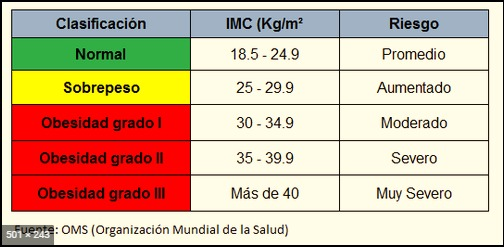

In [61]:
# UPSAMPLING
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score

precisan_df = df_artificial[df_artificial['precisa_examenes']==1]
no_precisan_df = df_artificial[df_artificial['precisa_examenes']==0]

cantidad_requerida = max(precisan_df.shape[0], no_precisan_df.shape[0])

upsampled_precisan_df = resample(precisan_df, n_samples=cantidad_requerida)
upsampled_no_precisan_df = resample(no_precisan_df, n_samples=cantidad_requerida)

upsampled_df_artificial = pd.concat([upsampled_precisan_df, upsampled_no_precisan_df], ignore_index=True)


X, y  = upsampled_df_artificial.drop('precisa_examenes', axis=1), upsampled_df_artificial['precisa_examenes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# svc = SVC(C=10, kernel='poly')
svc = SVC(C=1, kernel='linear')
svc.fit(X_train, y_train)

preds = svc.predict(X_test)

recall = recall_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)

upsampled_df_artificial.describe()
recall, accuracy
preds.mean()

SVC(C=1, kernel='linear')

,peso (kg),altura,fumador,presion_arterial_alta,afeccion_cardiaca,diabetes,precisa_examenes
count,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000
mean,1.683475,67.216262,0.127329,0.203106,0.137888,0.051553,0.500000
std,0.199806,13.654270,0.333445,0.402435,0.344890,0.221191,0.500155
min,0.974028,16.127218,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.546110,58.084430,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.682130,67.001193,0.000000,0.000000,0.000000,0.000000,0.500000
75%,1.816928,77.497824,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.575682,112.410839,1.000000,1.000000,1.000000,1.000000,1.000000


(0.7892857142857143, 0.8890977443609023)

0.41541353383458646

Fuimos probando con distintos parámetros del SVC, y quedándonos con alguno que tuviese recall relativamente alto. Buscamos esto para que no se escapen personas que sí deben realizarse exámenes. Si el recall era bajo, significa que estamos siendo demasiado estrictos al momento de mandar a alguien a hacerse los exámenes.

Igualmente hubo que tener cuidado con casos como el comentado (svc = SVC(C=10, kernel='poly'), aunque parecía sólo importar el kernel), pues daba recall 1, pero al fijarse en las predicciones saltaba rápidamente a la vista que era debido a que le meandaba hacer exámenes a todos. Al igual que en ejemplos mostrados debajo, hay que trabajar con datasets balanceados, e implementar quizás alguna técnica de upsampling.

## Parte 5

Tomaremos 3 datasets, para estudiar qué tan importante es contar con todas las columnas, con algunas, o con menos.
1. un dataset con todas las columnas
1. un dataset con columnas de mayor correlación con DEATH_EVENT
1. un dataset con columnas de mayor correlación con DEATH_EVENT, exceptuando tiempo y age (o sea, aspectos del cuerpo)

In [62]:
# X_train, X_test, y_train, y_test = 
X, y  = filtered_df.drop('DEATH_EVENT', axis=1), filtered_df['DEATH_EVENT']
complete = train_test_split(X, y, test_size=0.33, random_state=42)

X, y  = filtered_df[['serum_creatinine', 'ejection_fraction', 'age', 'time']], filtered_df['DEATH_EVENT']
max_correlation = train_test_split(X, y, test_size=0.33, random_state=42)

X, y  = filtered_df[['serum_creatinine', 'ejection_fraction']], filtered_df['DEATH_EVENT']
biological_max_correlation = train_test_split(X, y, test_size=0.33, random_state=42)


datasets = [
    complete,
    max_correlation,
    biological_max_correlation
]

Elegiremos varios modelos, y haremos búsqueda de hiperparámetros para quedarnos con el mejor modelo.

Las métricas a observar son recall y accuracy, puesto que queremos saber quienes tienen apenas chance de morir por accidentes cardiovasculares.

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dtc = DecisionTreeClassifier()

gnb = GaussianNB()

svcs = []
cs = [1, 5, 10]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for c in cs:
    for k in kernels:
        svc = SVC(C=c, kernel=k)
        svcs.append(svc)

rf = RandomForestClassifier(max_depth=2, random_state=0)


models = [dtc, gnb, *svcs, rf]

In [64]:
trained_models_per_dataset = []
for X_train, X_test, y_train, y_test in datasets:
    trained = []
    for model in models:
        clf = model.fit(X_train, y_train)
        trained.append(clf)
    trained_models_per_dataset.append(trained)

In [65]:
scores_per_model_per_dataset = [] # primero indexa por dataset, luego por modelo
for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
    # entrenamos cada modelo
    trained_clfs = []
    for model in models:
        clf = model.fit(X_train, y_train)
        trained_clfs.append(clf)
    
    scores = []
    for clf in trained_clfs:
        preds = clf.predict(X_test)
        recall = recall_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        scores.append((clf, recall, accuracy))
    scores_per_model_per_dataset.append(scores)  


In [66]:
scores_per_model_per_dataset

[[(DecisionTreeClassifier(), 0.42105263157894735, 0.7972972972972973),
  (GaussianNB(), 0.5263157894736842, 0.8378378378378378),
  (SVC(C=1, kernel='linear'), 0.42105263157894735, 0.8108108108108109),
  (SVC(C=1, kernel='poly'), 0.0, 0.7432432432432432),
  (SVC(C=1), 0.0, 0.7432432432432432),
  (SVC(C=1, kernel='sigmoid'), 0.0, 0.7162162162162162),
  (SVC(C=5, kernel='linear'), 0.42105263157894735, 0.8108108108108109),
  (SVC(C=5, kernel='poly'), 0.0, 0.7432432432432432),
  (SVC(C=5), 0.0, 0.7432432432432432),
  (SVC(C=5, kernel='sigmoid'), 0.10526315789473684, 0.5945945945945946),
  (SVC(C=10, kernel='linear'), 0.42105263157894735, 0.8108108108108109),
  (SVC(C=10, kernel='poly'), 0.0, 0.7432432432432432),
  (SVC(C=10), 0.0, 0.7432432432432432),
  (SVC(C=10, kernel='sigmoid'), 0.10526315789473684, 0.581081081081081),
  (RandomForestClassifier(max_depth=2, random_state=0),
   0.42105263157894735,
   0.7972972972972973)],
 [(DecisionTreeClassifier(), 0.5789473684210527, 0.81081081081081

### Resampling

Viendo que tenemos resultados muy malos de recall (en algunos casos, predice que nadie morirá y tiene recall 0 pero accuracy relativamente buena), vamos a upsamplear la cantidad de pacientes que mueren así no hay tanta class imbalance.

Veamos cómo está ahora:

In [67]:
total = filtered_df['DEATH_EVENT'].count()
muertos = filtered_df['DEATH_EVENT'].sum()
vivos = total-muertos

print(f'Total: {total}')
print(f'Muertos: {muertos} - {muertos/total*100 :.1f}%')
print(f'Vivos: {vivos} - {(vivos)/total*100 :.1f}%')

print(f'Ratio muertos:vivos : {muertos/muertos}:{vivos/muertos :.1f} ')

Total: 223
Muertos: 61 - 27.4%
Vivos: 162 - 72.6%
Ratio muertos:vivos : 1.0:2.7 


Si hacemos un resample:

In [68]:
filtered_df = filtered_df.drop("label_2_clusters", axis=1)\
                            .drop("label_3_clusters", axis=1)\
                            .drop("label_4_clusters", axis=1)\
                            .drop("label_5_clusters", axis=1)

muertos_df = filtered_df[filtered_df['DEATH_EVENT']==1]
vivos_df = filtered_df[filtered_df['DEATH_EVENT']==0]

cantidad_requerida = vivos_df.shape[0]

upsampled_muertos_df = resample(muertos_df, n_samples=cantidad_requerida)

upsampled_df = pd.concat([vivos_df, upsampled_muertos_df], ignore_index=True)

In [69]:
total = upsampled_df['DEATH_EVENT'].count()
muertos = upsampled_df['DEATH_EVENT'].sum()
vivos = total-muertos

print(f'Total: {total}')
print(f'Muertos: {muertos} - {muertos/total*100 :.1f}%')
print(f'Vivos: {vivos} - {(vivos)/total*100 :.1f}%')

print(f'Ratio muertos:vivos : {muertos/muertos}:{vivos/muertos :.1f} ')

Total: 324
Muertos: 162 - 50.0%
Vivos: 162 - 50.0%
Ratio muertos:vivos : 1.0:1.0 


Ahora ya está balanceado. Reentremos a ver si mejoran las cosas:

In [70]:
import numpy as np
from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = 
X, y  = upsampled_df.drop('DEATH_EVENT', axis=1), upsampled_df['DEATH_EVENT']
complete = train_test_split(X, y, test_size=0.33, random_state=42)

X, y  = upsampled_df[['serum_creatinine', 'ejection_fraction', 'age', 'time']], upsampled_df['DEATH_EVENT']
max_correlation = train_test_split(X, y, test_size=0.33, random_state=42)

X, y  = upsampled_df[['serum_creatinine', 'ejection_fraction']], upsampled_df['DEATH_EVENT']
biological_max_correlation = train_test_split(X, y, test_size=0.33, random_state=42)


datasets = [
    complete,
    max_correlation,
    biological_max_correlation
]


dtc = DecisionTreeClassifier()

gnb = GaussianNB()

svcs = []
cs = [1, 5, 10]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for c in cs:
    for k in kernels:
        svc = SVC(C=c, kernel=k)
        svcs.append(svc)

rf = RandomForestClassifier(max_depth=2, random_state=0)


models = [dtc, gnb, *svcs, rf]


trained_models_per_dataset = []
for X_train, X_test, y_train, y_test in datasets:
    trained = []
    for model in models:
        clf = model.fit(X_train, y_train)
        trained.append(clf)
    trained_models_per_dataset.append(trained)
    
    
scores_per_model_per_dataset = [] # primero indexa por dataset, luego por modelo
for i, (X_train, X_test, y_train, y_test) in enumerate(datasets):
    # entrenamos cada modelo
    trained_clfs = []
    for model in models:
        clf = model.fit(X_train, y_train)
        trained_clfs.append(clf)
    
    scores = []
    for clf in trained_clfs:
        preds = clf.predict(X_test)
        recall = recall_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        scores.append((clf, recall, accuracy))
    scores_per_model_per_dataset.append(scores)  



In [71]:
scores_per_model_per_dataset

[[(DecisionTreeClassifier(), 0.9272727272727272, 0.8037383177570093),
  (GaussianNB(), 0.8545454545454545, 0.8317757009345794),
  (SVC(C=1, kernel='linear'), 0.7090909090909091, 0.719626168224299),
  (SVC(C=1, kernel='poly'), 0.8, 0.5607476635514018),
  (SVC(C=1), 0.3090909090909091, 0.4485981308411215),
  (SVC(C=1, kernel='sigmoid'), 0.07272727272727272, 0.4766355140186916),
  (SVC(C=5, kernel='linear'), 0.6909090909090909, 0.7383177570093458),
  (SVC(C=5, kernel='poly'), 0.8, 0.5514018691588785),
  (SVC(C=5), 0.3090909090909091, 0.4766355140186916),
  (SVC(C=5, kernel='sigmoid'), 0.5636363636363636, 0.5233644859813084),
  (SVC(C=10, kernel='linear'), 0.7454545454545455, 0.7289719626168224),
  (SVC(C=10, kernel='poly'), 0.8, 0.5514018691588785),
  (SVC(C=10), 0.3090909090909091, 0.4672897196261682),
  (SVC(C=10, kernel='sigmoid'), 0.5636363636363636, 0.5233644859813084),
  (RandomForestClassifier(max_depth=2, random_state=0),
   0.8727272727272727,
   0.8598130841121495)],
 [(Decision

Vemos que mejoran los números de Recall, y la Accuracy permanece similar. Igualmente, capaz es medio apresurado decir que es un mejor modelo, porque los datos están repetidos.

Algo interesante es que los métodos de árboles mejoraron sustancialmente.

Nosotros elegiríamos el modelo SVC con C=10 y kernel="poly" ya que tiene el mayor recall: _(SVC(C=5, kernel='poly'), 0.9636363636363636, 0.8037383177570093)_ entrenado con el dataframe "upsampleado" incluyendo solo las columnas 'serum_creatinine', 'ejection_fraction', 'age', 'time'.

## Parte 6

Lo que más nos llamó la atención en este trabajo fue que las patologías o comportamientos de los pacientes que nosotros pensamos a priori que seguro tenían un impacto muy grande en determinar si la persona moría a causa del accidente cardiovascular o no, resultaron ser bastante insignificantes (fumador y diabetes).

Algo que tampoco esperábamos era alcanzar resultados distintos a los mostrados en el paper: ahí mencionan que obtienen los mejores resultados con el modelos "RandomForest" mientras que nosotros los obtuvimos con "SVC". Esto puede deberese a que probamos varias instancias de modelos SVC variando los parámetros mientras que solo probamos con una instancia de RandomForest para cada versión del dataset.

Algo en lo que sí coincidimos con el paper es que obtuvimos mejores resultados usando un dataset con solo las columnas más correlacionadas con el "DEATH_EVENT". Nosotros usamos 'serum_creatinine', 'ejection_fraction', 'age', 'time' mientras que en el paper no usaron "age". Tomamos esta decisión porque en la parte 2 vimos que una característica de las poblaciones con mayor riesgo de muerte era que en promedio tenían una edad mayor.

Este trabajo significó la puesta en práctica de todo lo aprendido en el curso sobre aprendizaje supervisado, no supervisado y EDAs de datasets por lo cual estuvo bueno para redondear el semestre.

In [72]:
import pickle

pickle.dump(svc,open(f'./form-model', 'wb'))
pickle.dump(scores_per_model_per_dataset[1][-4][0],open(f'./clinical-model', 'wb'))

In [73]:
print('Runeo todo')

Runeo todo
